# Package

In [2]:
#Torch related package
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchviz

In [3]:
#cuda related package
import torch.cuda
import torch.backends.cudnn as cudnn
print(torch.backends.cudnn.version())

6021


In [4]:
# Other package
import time
import random
from ggplot import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists
import csv

/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/tanguy/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/tanguy/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
#%run Annexe.ipynb #Good trick to launch another notebook

# Commentaire pour la suite (TODO)

Le batch normalisation, il y en existe plusieurs, regarder exactement lequel on veut.

On peut enlever le biais dans les convolutions avant la normalisation

Le diminution de la taille des images, pas clair cette division par deux....

Change la fonction de cout

Il faut enlever les biais quand il y a une batch normalisation apres

# Entrainement 

# CityscapesLoader

In [6]:
class color():
    convolution        = "darkgoldenrod1"
    subSampling        = "darkgoldenrod" 
    fullConvolution    = "firebrick1"
    upSampling         = "firebrick"
    batchNormalization = "deepskyblue3"
    relu               = "darkolivegreen3"
    add                = "bisque3"
    dropout            = "darkviolet"

In [379]:
#class Label():
    def __init__(self, name, total_id, train_id, category, cat_id, has_instances, ignore_in_eval, color):
        self.name = name
        self.total_id = total_id
        self.train_id = train_id
        self.category = category
        self.cat_id = cat_id
        self.has_instances = has_instances
        self.ignore_in_eval = ignore_in_eval
        self.color = color


In [7]:

from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

#--------------------------------------------------------------------------------
# Assure single instance name
#--------------------------------------------------------------------------------

# returns the label name that describes a single instance (if possible)
# e.g.     input     |   output
#        ----------------------
#          car       |   car
#          cargroup  |   car
#          foo       |   None
#          foogroup  |   None
#          skygroup  |   None
def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name
"""
#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

# just a dummy main
if __name__ == "__main__":
    # Print all the labels
    print("List of cityscapes labels:")
    print("")
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval' ))
    print("    " + ('-' * 98))
    for label in labels:
        print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval ))
    print("")

    print("Example usages:")

    # Map from name to label
    name = 'car'
    id   = name2label[name].id
    print("ID of label '{name}': {id}".format( name=name, id=id ))

    # Map from ID to label
    category = id2label[id].category
    print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

    # Map from trainID to label
    trainId = 0
    name = trainId2label[trainId].name
    print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))
"""
a=4

In [173]:
import os

import numpy as np
import torch
from PIL import Image
from torch.utils import data

num_classes = 19
ignore_label = 255
root = "/media/tanguy/Seagate Expansion Drive/Cityscapes_Copy"

palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)


def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask


def make_dataset(quality, mode):
    assert (quality == 'fine' and mode in ['train', 'val']) or \
           (quality == 'coarse' and mode in ['train', 'train_extra', 'val'])

    if quality == 'coarse':
        if (mode == 'train_extra'):
            img_dir_name = path + '/leftImg8bit_trainextra'
        else:
            img_dir_name = path + '/leftImg8bit'
        mask_path = os.path.join(root, 'gtCoarse', 'gtCoarse', mode)
        mask_postfix = '_gtCoarse_labelIds.png'
    else:
        img_dir_name = 'leftImg8bit'
        mask_path = os.path.join(root, 'gtFine', mode)
        mask_postfix = '_gtFine_labelIds.png'
    img_path = os.path.join(root, img_dir_name, mode)
    assert os.listdir(img_path) == os.listdir(mask_path)
    items = []
    categories = os.listdir(img_path)
    for c in categories:
        c_items = [name.split('_leftImg8bit.png')[0] for name in os.listdir(os.path.join(img_path, c))]
        for it in c_items:
            item = (os.path.join(img_path, c, it + '_leftImg8bit.png'), os.path.join(mask_path, c, it + mask_postfix))
            items.append(item)
    return items


class CityScapes_final(data.Dataset):
    def __init__(self, quality, mode, joint_transform=None, sliding_crop=None, transform=None, target_transform=None):
        self.imgs = make_dataset(quality, mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.quality = quality
        self.mode = mode
        self.joint_transform = joint_transform
        self.sliding_crop = sliding_crop
        self.transform = transform
        self.target_transform = target_transform
        self.id_to_trainid = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 2: ignore_label,
                              3: ignore_label, 4: ignore_label, 5: ignore_label, 6: ignore_label,
                              7: 0, 8: 1, 9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 13: 4,
                              14: ignore_label, 15: ignore_label, 16: ignore_label, 17: 5,
                              18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14,
                              28: 15, 29: ignore_label, 30: ignore_label, 31: 16, 32: 17, 33: 18}

    def __getitem__(self, index):
        img_path, mask_path = self.imgs[index]
        img, mask = Image.open(img_path).convert('RGB'), Image.open(mask_path)

        mask = np.array(mask)

        mask_copy = mask.copy()
        
        for k, v in self.id_to_trainid.items():
            mask_copy[mask == k] = v
            
        mask = Image.fromarray(mask_copy.astype(np.uint8))
        
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
                 
        if self.sliding_crop is not None:
            img_slices, mask_slices, slices_info = self.sliding_crop(img, mask)
            
            if self.transform is not None:
                img_slices = [self.transform(e) for e in img_slices]
            if self.target_transform is not None:
                mask_slices = [self.target_transform(e) for e in mask_slices]
            img, mask = torch.stack(img_slices, 0), torch.stack(mask_slices, 0)
            return img, mask.long(), torch.LongTensor(slices_info)
        else:
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                mask = self.target_transform(mask)
            mask = torch.squeeze(mask)
            #mask_copy = torch.rand(19,19,19)            
            #for k in range(19):
            #    mask_copy[k,:,:] = (mask == k)*1

            return img, mask.long()
        
    def __len__(self):
        return len(self.imgs)

In [174]:
"""train return nothing but modify the weight of the network and call save_error to store the error.
    (0) = parameters : list of parameters of the network
    (1) = x_train : inputs of the training set
    (2) = y_train : outputs of the training set
    (3) = x_validation : inputs of the validation set
    (4) = y_validation : outputs of the validation set
"""
def train2(parameters,network,train_loader,val_loader):
     
    # create your optimizer
    optimizer = optim.Adam(params = network.parameters(), lr = parameters.learning_rate,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)
    for epoch in range(1):

        for i,(x_batch, y_batch) in enumerate(train_loader):

            # zero the gradient buffers
            optimizer.zero_grad()
            x_batch, y_batch = Variable(x_batch), Variable(y_batch)
            #indices = random_perm[batch:min(batch+batch_size,x_train_len)]
            #x_batch, y_batch = x_train[indices], y_train[indices]

            # Compute the forward function


            y_batch_estimated = network(x_batch)
            print(y_batch)
            print(y_batch_estimated)
            #Get the error
            loss = criterion(y_batch_estimated, y_batch)            
            #Compute the backward function
            loss.backward()
            break

            # Does the update according to the optimizer define above
            optimizer.step()

            # Save the error in CSV
            save_error(x_train,y_train,x_validation,y_validation,network,epoch,
                       parameters.name_network,parameters.train_number,path_CSV = parameters.path_CSV)
    return()

In [175]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.CenterCrop(19),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.CenterCrop(19),
    transforms.ToTensor()
])

path = "/media/tanguy/Seagate Expansion Drive/Cityscapes_Copy"

parameters = Parameters(nColumns = 2, learning_rate=0.01, nFeatMaps = [3,6],dropFactor = 0.1,
                        number_classes = 19, weight_decay = 5*10**(-6), beta1 = 0.9,
                        beta2 = 0.999, epsilon = 1*10**(-8), width_image = 2048, height_image = 1024,
                        nFeatureMaps_init = 3, batch_size = 2,epoch_number = 10,
                       name_network = "test", train_number = 0,path_CSV = "CSV/")


train_dataset = CityScapes_final('fine', 'train',transform = transform, target_transform = target_transform)
val_dataset = CityScapes_final('fine', 'val',transform = transform, target_transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters.batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=0)



# Define the GridNet
network = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes,
                  nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)

init_csv(name_network = parameters.name_network,train_number = parameters.train_number,path_CSV = parameters.path_CSV)


TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !


In [176]:
train2(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)


Variable containing:
(0 ,.,.) = 
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   

()

In [78]:
train2(network = network, parameters = parameters, train_loader = train_loader, val_loader = val_loader)

plot_loss(name_network = parameters.name_network, train_number = parameters.train_number)

plot_confusion(parameters.name_network,parameters.train_number)

#  GridNet

In [10]:
class firstConv(nn.Module):
    
    """
    (1) = nInputs : number of features map for the input
    (2) = nOutputs : number of features map for the output
    This is the first convolution used to enter into the grid.
    """
    def __init__(self,nInputs):
        super(firstConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nInputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels = nInputs, out_channels = nInputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch2 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)
                
        self.ReLU2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ReLU1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ReLU2(x)
        return x

    
net = firstConv(nInputs = 3)
print(net)

firstConv(
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU1): ReLU()
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU2): ReLU()
)


In [11]:
class convSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    (3) = dropFactor : Total Dropout on the entire Sequence, there is a probability p = dropFactor that
        the residual is deleted.
    This class reprensent a residual bloc that doesn't change number nor the size of the features maps
    """
    def __init__(self,nInputs,nOutputs,dropFactor):
        super(convSequence, self).__init__()
        self.dropFactor = dropFactor
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU2 = nn.ReLU()
        
        
    def forward(self, x_init):
        x = self.batch1(x_init)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        # Small trick that transform boolean into integer
        x = ((random.random() > self.dropFactor) * 1) * x
        x = x_init + x
        return x

    
net = convSequence(nInputs = 3,nOutputs = 3,dropFactor = 0.1)
print(net)

convSequence(
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)


In [12]:
class subSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that reduce the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(subSamplingSequence, self).__init__()
        
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

    def forward(self, x):
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x

    
network = subSamplingSequence(nInputs = 3,nOutputs = 6)
print(network)
a = torch.randn(2, 3, 7, 7)
inputs = Variable(a)
out = network(inputs)
print(out.size())

subSamplingSequence(
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv1): Conv2d (3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)
torch.Size([2, 6, 4, 4])


In [13]:
class upSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that increase the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(upSamplingSequence, self).__init__()
        
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.convTranspose1 = nn.ConvTranspose2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

        
    def forward(self, x):
        x = self.batch1(x)
        x = self.convTranspose1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x


network = upSamplingSequence(nInputs = 6,nOutputs = 3)
print(network)
a = torch.randn(2, 6, 16, 16)
inputs = Variable(a)
out = network(inputs)
print(out.size())

#

upSamplingSequence(
  (batch1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
  (convTranspose1): ConvTranspose2d (6, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (ReLU1): ReLU()
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ReLU2): ReLU()
)
torch.Size([2, 3, 31, 31])


In [14]:
class lastConv(nn.Module):
    
    """
    (1) = nInputs : number of features map for the input
    (2) = nOutputs : number of features map for the output
    This class represente the last Convolution of the network before the prediction
    """
    def __init__(self,nInputs,nOutputs):
        super(lastConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch1 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
                
        self.ReLU2 = nn.ReLU()

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.ReLU1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.ReLU2(x)
        return x

    
net = lastConv(nInputs = 3,nOutputs = 3)
print(net)


lastConv(
  (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU1): ReLU()
  (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (ReLU2): ReLU()
)


In [15]:
class gridNet(nn.Module):
    
    """
    (1) = nInput : number of features maps for the input
    (2) = nOutput : number of features maps for the output
    (3) = nColumns : number of columns of the gridNet, this number should be divisible by two.
    It count the number of bloc +1
    (4) = nFeatMaps : number of feature at each row of the gridNet
    (5) = dropFactor : factor witch control the dropout of an entire bloc 
    """
    def __init__(self,nInputs, nOutputs, nColumns, nFeatMaps, dropFactor):
        super(gridNet, self).__init__()
        
        #Define some parameters as an attribut of the class
        len_nfeatureMaps = len(nFeatMaps)
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.len_nfeatureMaps = len_nfeatureMaps
        
        # A normalisation before any computation
        self.batchNormInitial = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        # The first convolution before entering into the grid.
        self.firstConv = firstConv(nInputs = nInputs)
        
        
        # We create the Grid. We will creat conv and sub/up sequences with different name.
        # The name is : "sequenceName" + starting position of the sequence(i,j) + "to" + ending position (k,l)
        for i in range(len(nFeatMaps)):
            for j in range(nColumns):
                #We don t creat a residual bloc on the last column
                if(j < (nColumns - 1)):
                    setattr(self, "convSequence" + str(i) + "_" + str(j) + "to" + str(i) + "_" + str(j + 1),
                            convSequence(nFeatMaps[i], nFeatMaps[i],dropFactor))
                
                #We creat subSampling only on half of the grid and not in the last row
                if(j < (nColumns // 2) and i < (len(nFeatMaps)-1)):
                    setattr(self, "subSamplingSequence" + str(i) + "_" + str(j) + "to" + str(i + 1) + "_" + str(j),
                            subSamplingSequence(nFeatMaps[i], nFeatMaps[i+1]))
                
                #Welook a the other half but not the first row
                if(j >= (nColumns // 2) and i > 0):
                    setattr(self, "upSamplingSequence" + str(i) + "_" + str(j) + "to" + str(i - 1) + "_" + str(j),
                            upSamplingSequence(nFeatMaps[i], nFeatMaps[i-1]))

        # The last convolution before the result.
        self.lastConv = lastConv(nInputs = nFeatMaps[0], nOutputs = nOutputs)    
        
        self.batchNormFinal = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0,affine=True)
        
        self.logsoftmax1 = nn.LogSoftmax()
        
        
    
    """This function return the fusion of the actual value on (i,j) and the new data which come from the sampling
    (1) = X_i_j : The value on the grid a the position (i,j)
    (2) = SamplingSequence : The sampling that should be added to the point (i,j)
    """
    def addTransform(self,X_i_j,SamplingSequence):
        return(X_i_j + SamplingSequence)
    
    
    
    def forward(self, x):

        # A normalisation before any computation
        x = self.batchNormInitial(x)
        # The first convolution before entering into the grid.
        x = self.firstConv(x)
        
        # X is the matrix that represente the values of the features maps at the point (i,j) in the grid.
        X = [[0 for i in range(self.nColumns)] for j in range(self.len_nfeatureMaps)]
        #The input of the grid is on (0,0)
        X[0][0] = x
        
        # Looking on half of the grid, with sumsampling and convolution sequence
        for j in range(self.nColumns//2):
            for i in range(self.len_nfeatureMaps):
                #For the first column, there is only subsampling
                if(j > 0):
                    #This syntaxe call self.conSequencei_(j-1)toi_j(X[i][j-1])
                    X[i][j] = getattr(self,"convSequence"
                                      + str(i) + "_" + str(j-1) + "to" + str(i) + "_" + str(j))(X[i][j-1])
                
                # For the first row, there is only ConvSequence (residual bloc)
                if(i > 0):
                    X[i][j] = self.addTransform(X[i][j] , getattr(self,"subSamplingSequence"
                                                + str(i-1) + "_" + str(j) + "to" + str(i) + "_" + str(j))(X[i-1][j]))

        # Looking on the other half of the grid
        for j in range(self.nColumns//2,self.nColumns):
            for i in range(self.len_nfeatureMaps-1,-1,-1):
                X[i][j] = getattr(self,"convSequence" +
                                      str(i) + "_" + str(j-1) + "to" + str(i) + "_" + str(j))(X[i][j-1])

                
                # There is no upSampling on the last row
                if(i < (self.len_nfeatureMaps - 1)):
                    X[i][j] = self.addTransform(X[i][j], getattr(self,"upSamplingSequence"
                                                + str(i+1) + "_" + str(j) + "to" + str(i) + "_" + str(j))(X[i+1][j]))

        x_final = self.lastConv(X[0][self.nColumns - 1])

        if(False):
            print("Size of different X_i_j")
            for i1,i2 in enumerate(X):
                for j1,j2 in enumerate(i2):
                    print("Dim(X(" + str(i1) + ")(" + str(j1) + ")) : ",j2.size())
             

        return x_final


network = gridNet(nInputs = 3,nOutputs = 19, nColumns = 4, nFeatMaps = [3,6,12,24], dropFactor = 0.1)
print(network)


gridNet(
  (batchNormInitial): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
  (firstConv): firstConv(
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU1): ReLU()
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (ReLU2): ReLU()
  )
  (convSequence0_0to0_1): convSequence(
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU1): ReLU()
    (batch2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv2): Conv2d (3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU2): ReLU()
  )
  (subSamplingSequence0_0to1_0): subSamplingSequence(
    (batch1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv2d (3, 6, kernel_size=(3, 3), stride=(2, 2),

# Train

In [16]:
class Parameters():
    def __init__(self,nColumns, nFeatMaps, dropFactor,learning_rate,number_classes, beta1, beta2,epsilon,
                weight_decay,width_image, height_image,nFeatureMaps_init,batch_size,epoch_number,name_network,
                 train_number,path_CSV):
        super(Parameters, self).__init__()
        # Image
        self.number_classes = number_classes
        self.width_image = width_image
        self.height_image = height_image
        # Number of feature map at the begining, if RGB image it would be 3
        self.nFeatureMaps_init = nFeatureMaps_init
        
        # GridNet
        self.nColumns = nColumns
        self.nFeatMaps = nFeatMaps
        self.name_network = name_network
        self.train_number = train_number
        self.path_CSV = path_CSV
        
        # Learning
        self.dropFactor = dropFactor
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epoch_number = epoch_number


In [159]:
"""Define the loss function between the y_train_estimated and y_train
    (0) = y_estimated : result of train(x) which is the forward action
    (1) = y : Label associated with x
"""
def criterion(y_estimated, y):
    nllcrit = nn.NLLLoss()
    print(y_estimated)
    print(y)
    a = F.log_softmax(y_estimated, dim = 1)
    return nllcrit(a, y)

In [160]:
"""Define the loss function between the y_train_estimated and y_train and return a vector with the epoch the value
    and if the criterion is used on training or validation set.
    (0) = y_estimated : result of train(x) which is the forward action
    (1) = y : Label associated with x
    (2) = epoch : the actual epoch of the learning
    (3) = Set : string which is train of validation
"""
def criterion_pd_format(y_estimated, y, epoch, Set):
    nllcrit = nn.NLLLoss2d()
    loss = nllcrit(F.log_softmax(y_estimated, dim = 1), y)
    return ([epoch, loss.data[0], Set, epoch])

In [161]:
"""train return nothing but modify the weight of the network and call save_error to store the error.
    (0) = parameters : list of parameters of the network
    (1) = x_train : inputs of the training set
    (2) = y_train : outputs of the training set
    (3) = x_validation : inputs of the validation set
    (4) = y_validation : outputs of the validation set
"""
def train(parameters2,network,x_train,y_train,x_validation,y_validation):

    # We will use this one a lot, so we compute it now
    x_train_len = x_train.size()[0]

    # create your optimizer
    optimizer = optim.Adam(params = network.parameters(), lr = parameters.learning_rate,
                           betas = (parameters.beta1, parameters.beta2),
                           eps = parameters.epsilon, weight_decay = parameters.weight_decay)

    for epoch in range(parameters.epoch_number):
        
        # We apply a random permutation at each epoch
        random_perm = torch.randperm(x_train_len)
        
        #trainloader=torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
        #testloader=torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
        
        for batch in range(0,x_train.size()[0], parameters2.batch_size):
            # zero the gradient buffers
            optimizer.zero_grad()
            indices = random_perm[batch:min(batch + parameters2.batch_size,x_train_len)]
            x_batch, y_batch = x_train[indices], y_train[indices]
            
            # Compute the forward function
            y_batch_estimated = network(x_batch)

            #Get the error
            loss = criterion(y_batch_estimated, y_batch)            
            #Compute the backward function
            loss.backward()

            # Does the update according to the optimizer define above
            optimizer.step()

        # Save the error in CSV
        save_error(x_train,y_train,x_validation,y_validation,network,epoch,
                   parameters.name_network,parameters.train_number,path_CSV = parameters.path_CSV)
    return()

In [164]:
a = torch.rand(4,3,19,19)
x_train = Variable(a)
b = torch.randn(4,19,19)%19
b = b.long()
y_train = Variable(b)
x_validation = x_train
y_validation = y_train
parameters2 = Parameters(nColumns = 2, learning_rate=0.01, nFeatMaps = [3,6],dropFactor = 0.1,
                        number_classes = 19, weight_decay = 5*10**(-6), beta1 = 0.9,
                        beta2 = 0.999, epsilon = 1*10**(-8), width_image = 19, height_image = 19,
                        nFeatureMaps_init = 3, batch_size = 2,epoch_number = 3,
                       name_network = "test", train_number = 0,path_CSV = "CSV/")



# Define the GridNet
network2 = gridNet(nInputs = parameters.nFeatureMaps_init,nOutputs = parameters.number_classes,
                  nColumns = parameters.nColumns,nFeatMaps = parameters.nFeatMaps, dropFactor = parameters.dropFactor)

init_csv(name_network = parameters.name_network,train_number = parameters.train_number,path_CSV = parameters.path_CSV)

train(parameters2 ,network2,x_train,y_train,x_validation,y_validation)

TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !
Variable containing:
(0 ,0 ,.,.) = 
  0.0245  0.0000  0.0402  ...   0.0366  0.0838  0.0425
  0.0025  0.1378  0.0000  ...   0.4204  0.0000  0.0495
  0.0271  0.0000  0.0432  ...   0.0553  0.0000  0.1664
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0864  0.0229  0.0270
  0.1932  0.2238  0.1669  ...   0.0460  0.0582  0.0928
  0.0000  0.0212  0.0000  ...   0.1277  0.1241  0.0629

(0 ,1 ,.,.) = 
  0.0000  0.0000  0.0714  ...   0.0197  0.0448  0.0000
  0.0000  0.0000  0.1236  ...   0.1489  0.0395  0.0000
  0.0000  0.0437  0.1151  ...   0.0334  0.0288  0.0000
           ...             ⋱             ...          
  0.0000  0.0028  0.0000  ...   0.0055  0.0073  0.0115
  0.0768  0.0000  0.0839  ...   0.0000  0.0334  0.0318
  0.0000  0.0480  0.0000  ...   0.0000  0.0188  0.0000

(0 ,2 ,.,.) = 
  0.0000  0.0000  0.1564  ...   0.0000  0.0000  0.0000
  0.0000  0.0739  0.1269  ...   0.

Variable containing:
(0 ,0 ,.,.) = 
  0.0341  0.1577  0.0000  ...   0.0000  0.0000  0.1282
  0.0619  0.1274  0.0000  ...   0.0000  0.0970  0.0658
  0.0000  0.0839  0.0000  ...   0.0210  0.0000  0.0370
           ...             ⋱             ...          
  0.0616  0.0000  0.0000  ...   0.0226  0.2077  0.2122
  0.1350  0.2178  0.1182  ...   0.0000  0.2414  0.1792
  0.1247  0.1755  0.0000  ...   0.2391  0.1447  0.1382

(0 ,1 ,.,.) = 
  0.0268  0.0955  0.1835  ...   0.1153  0.0000  0.0000
  0.0441  0.2188  0.2255  ...   0.1898  0.0995  0.0401
  0.0166  0.1257  0.0000  ...   0.0000  0.2374  0.0000
           ...             ⋱             ...          
  0.0000  0.0365  0.0331  ...   0.0000  0.1620  0.0000
  0.0143  0.0998  0.0065  ...   0.2174  0.0746  0.0000
  0.0000  0.0000  0.1279  ...   0.0000  0.0000  0.0113

(0 ,2 ,.,.) = 
  0.0041  0.0000  0.0000  ...   0.0000  0.0000  0.0418
  0.0000  0.0132  0.0000  ...   0.0124  0.0000  0.0000
  0.0000  0.0011  0.0037  ...   0.0517  0.0121  0.00

Variable containing:
(0 ,0 ,.,.) = 
  0.1873  0.1401  0.2287  ...   0.2713  0.0000  0.3707
  0.0726  0.0000  0.0000  ...   0.4133  0.0000  0.4613
  0.1155  0.2738  0.2657  ...   0.2249  0.0000  0.5037
           ...             ⋱             ...          
  0.1752  0.1752  0.0457  ...   0.2786  0.0000  0.3704
  0.0000  0.4644  0.3436  ...   0.5390  0.2895  0.4366
  0.2884  0.4327  0.1425  ...   0.1879  0.0000  0.3672

(0 ,1 ,.,.) = 
  0.2258  0.2517  0.1601  ...   0.0477  0.2534  0.2480
  0.2624  0.1311  0.1609  ...   0.2331  0.3916  0.0000
  0.2525  0.1778  0.2991  ...   0.1969  0.1786  0.0323
           ...             ⋱             ...          
  0.1780  0.1513  0.2535  ...   0.1152  0.4193  0.1071
  0.3700  0.0672  0.2411  ...   0.2293  0.2258  0.0000
  0.3501  0.2840  0.2881  ...   0.2219  0.3709  0.1173

(0 ,2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.00

()

# Save Data

In [20]:
""" Creat two CSV files in wich the data of the training/validation will be store.
    (0) = path : path to store the CSV files
    (1) = name_network : name of the network associated with the CSV files
    (2) = train_number : number of train associated with the CSV files
"""
def init_csv(path_CSV,name_network,train_number):
    
    # Stop the program if the CSV file already exist !
    if(exists(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv")):
        print("TODO ici il faudra faire arreter le programme ! On ecrase les fichiers !")
        #TODO ici il faudra faire arreter le programme !
    
    # header of the futur Pandas DataFrames
    header_confMat = ["Set","Value","Target","Prediction","Epoch"]
    header_loss = ["Value","Set","Epoch"]
    
    # Try to open the file and write the header
    with open(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv", 'w') as csvfile:
        cwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        cwriter.writerow(header_confMat)

    # Try to open the file and write the header
    with open(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv", 'w') as csvfile:
        cwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        cwriter.writerow(header_loss)

In [21]:
def save_error(x_train,y_train,x_validation,y_validation,network,epoch,name_network,train_number,path_CSV):
    
    #Compute the forward function for the train and the validation
    y_train_estimated = network(x_train)
    y_validation_estimated = network(x_validation)
    
    # compute the matrice of confusion between classes
    conf_mat_train = IoU_pd_format(y_train_estimated, y_train, Set = "train", epoch = epoch)
    conf_mat_validation = IoU_pd_format(y_validation_estimated, y_validation, Set = "validation", epoch = epoch)
    
    with open(path_CSV + "CSV_confMat_" + name_network + str(train_number) + ".csv", 'a') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows(conf_mat_train)
        writer.writerows(conf_mat_validation)

    loss_train = criterion_pd_format(y_estimated = y_train_estimated,y = y_train,epoch=epoch,Set = "train")
    loss_validation = criterion_pd_format(y_estimated = y_validation_estimated,y = y_validation,
                                          epoch=epoch, Set= "validation")

    with open(path_CSV + "CSV_loss_" + name_network + str(train_number) + ".csv", 'a') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows([loss_train])
        writer.writerows([loss_validation])


# Test function

In [22]:
"""
    Test function : IoU
    Return a matrix of confusion in a good format to creat a pandas DataFrame
    (0) = y_estimated : result of train(x) which is the forward action
    (1) = y : Label associated with x
    (2) = epoch : the actual epoch of the learning
    (3) = Set : string which is train of validation
"""
def IoU_pd_format(y_estimated, y, Set, epoch):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_estimated, dim=1)[1]

    #Creat the confusion matrix, only the second column will have the value
    confusion_matrix = [[0] * 6 for i in range(parameters.number_classes**2)]
    
    pred = pred.view(-1)
    target = y_train.view(-1)

    # We will normalise the value in the matrix. We don t want to be influence by the size of the batch
    normalisation_value = y.size()
    # It is also possible to add the size of the image to normalise
    normalisation_value = normalisation_value[0]# * normalisation_value[1] * normalisation_value[2]
    
    # Double loop over the number of classes at each iteration we add the intersection
    # i will be the number of iteration
    i = 0
    for cls1 in range(parameters.number_classes):
        pred_inds = pred == cls1
        
        for cls2 in range(parameters.number_classes):
            
            i = cls1*parameters.number_classes + cls2
            
            target_inds = target == cls2
            # Intersection is the value predicted of class cls2 and are in reality class cls1
            intersection = (pred_inds*target_inds).long().sum().data.cpu()[0]
            
            #First line is index that will be usefull for the dataFrame
            confusion_matrix[i][0] = i + epoch * parameters.number_classes * parameters.number_classes
            # Traning or validation set
            confusion_matrix[i][1] = Set
            # The value normalised
            confusion_matrix[i][2] = intersection/normalisation_value
            # Associated with this value we keep the two classes
            confusion_matrix[i][3] = "class" + str(cls1)
            confusion_matrix[i][4] = "class" + str(cls2)
            # The epoch associated
            confusion_matrix[i][5] = epoch

    return(confusion_matrix)
    

# Resize

In [23]:
def resize(x_train,y_train):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-23-6d59207a1470>, line 2)

In [24]:
def 

SyntaxError: invalid syntax (<ipython-input-24-7d1812463cd5>, line 1)

# Plot

In [25]:
def plot_loss(name_network,train_number):
    loss_DF = pd.read_csv("CSV/CSV_loss_" + name_network + str(train_number) + ".csv")
    my_plot_loss = ggplot(aes(x="Epoch", y="Value",color = "Set"),data = loss_DF) + geom_line() 
    print(my_plot_loss)

In [26]:
def plot_confusion(name_network,train_number):
    conf_DF = pd.read_csv("CSV/CSV_confMat_" + name_network + str(train_number) + ".csv")
    a = conf_DF[conf_DF['Prediction'].apply(lambda x: x=="class0")]
    my_plot_conf_mat = ggplot(aes(x = "Epoch", y = "Value", color = "Target"),data = a) + geom_line()
    print(my_plot_conf_mat)

# Graphical representation of the grid

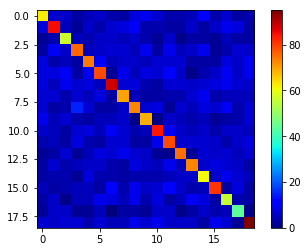

In [244]:
def plot_training(loss_train,conf_mat_train,IoU_classes_train,IoU_total_train):
    fig = plt.figure(1)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_mat_train[-1]), cmap=plt.cm.jet, 
                    interpolation='nearest')
    cb = fig.colorbar(res)
    plt.show()
    
    ggplot(aes(),data = IoU_classes_train)+ geom_point(x="0",y="1")
    

    



plot_training(loss_train,conf_mat_train,IoU_classes_train,IoU_total_train)

In [46]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.autograd import Variable, Function
from collections import defaultdict
import graphviz

"""
This is a rather distorted implementation of graph visualization in PyTorch.
This implementation is distorted because PyTorch's autograd is undergoing refactoring right now.
- neither func.next_functions nor func.previous_functions can be relied upon
- BatchNorm's C backend does not follow the python Function interface
- I'm not even sure whether to use var.creator or var.grad_fn (apparently the source tree and wheel builds use different
  interface now)
As a result, we are forced to manually trace the graph, using 2 redundant mechanisms:
- Function.__call__: this allows us to trace all Function creations. Function corresponds to Op in TF
- Module.forward_hook: this is needed because the above method doesn't work for BatchNorm, as the current C backend does
  not follow the Python Function interface. 
To do graph visualization, follow these steps:
1. register hooks on model: register_vis_hooks(model)
2. pass data through model: output = model(input)
3. remove hooks           : remove_vis_hooks()
4. perform visualization  : save_visualization(name, format='svg') # name is a string without extension
"""


old_function__call__ = Function.__call__

def register_creator(inputs, creator, output):
    """
    In the forward pass, our Function.__call__ and BatchNorm.forward_hook both call this method to register the creators
    inputs: list of input variables
    creator: one of
        - Function
        - BatchNorm module
    output: a single output variable
    """
    cid = id(creator)
    oid = id(output)
    if oid in vars: 
        return
    # connect creator to input
    for input in inputs:
        iid = id(input)
        func_trace[cid][iid] = input
        # register input
        vars[iid] = input
    # connect output to creator
    assert type(output) not in [tuple, list, dict]
    var_trace[oid][cid] = creator
    # register creator and output and all inputs
    vars[oid] = output
    funcs[cid] = creator

hooks = []

def register_vis_hooks(model):
    global var_trace, func_trace, vars, funcs
    remove_vis_hooks()
    var_trace  = defaultdict(lambda: {})     # map oid to {cid:creator}
    func_trace = defaultdict(lambda: {})     # map cid to {iid:input}
    vars  = {}                               # map vid to Variable/Parameter
    funcs = {}                               # map cid to Function/BatchNorm module
    hooks = []                               # contains the forward hooks, needed for hook removal

    def hook_func(module, inputs, output):
        assert 'BatchNorm' in mod.__class__.__name__        # batchnorms don't have shared superclass
        inputs = list(inputs)
        for p in [module.weight, module.bias]:
            if p is not None:
                inputs.append(p)
        register_creator(inputs, module, output)

    for mod in model.modules():
        if 'BatchNorm' in mod.__class__.__name__:           # batchnorms don't have shared superclass
            hook = mod.register_forward_hook(hook_func)
            hooks.append(hook)

    def new_function__call__(self, *args, **kwargs):
        inputs =  [a for a in args            if isinstance(a, Variable)]
        inputs += [a for a in kwargs.values() if isinstance(a, Variable)]
        output = old_function__call__(self, *args, **kwargs)
        register_creator(inputs, self, output)
        return output

    Function.__call__ = new_function__call__


def remove_vis_hooks():
    for hook in hooks:
        hook.remove()

    Function.__call__ = old_function__call__


def save_visualization(name, format='svg'):
    g = graphviz.Digraph(format=format)
    def sizestr(var):
        size = [int(i) for i in list(var.size())]
        return str(size)
    # add variable nodes
    for vid, var in vars.iteritems():
        if isinstance(var, nn.Parameter):
            g.node(str(vid), label=sizestr(var), shape='ellipse', style='filled', fillcolor='red')
        elif isinstance(var, Variable):
            g.node(str(vid), label=sizestr(var), shape='ellipse', style='filled', fillcolor='lightblue')
        else:
            assert False, var.__class__
    # add creator nodes
    for cid in func_trace:
        creator = funcs[cid]
        g.node(str(cid), label=str(creator.__class__.__name__), shape='rectangle', style='filled', fillcolor='orange')
    # add edges between creator and inputs
    for cid in func_trace:
        for iid in func_trace[cid]:
            g.edge(str(iid), str(cid))
    # add edges between outputs and creators
    for oid in var_trace:
        for cid in var_trace[oid]:
            g.edge(str(cid), str(oid))
    g.render(name)
class subSamplingSequence(nn.Module):
    
    """
    (1) = nInput : number of features map for the input
    (2) = nOutput : number of features map for the output
    This class represente a bloc that reduce the resolution of each feature map(factor2)
    """
    def __init__(self, nInputs, nOutputs):
        super(subSamplingSequence, self).__init__()
        self.Seque
        self.batch1 = nn.BatchNorm2d(num_features = nInputs, eps=1e-05, momentum=0.1,affine=True)

        self.conv1 = nn.Conv2d(in_channels = nInputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(2,2), padding=(1,1), dilation=1, groups=1, bias=True)
        
        self.ReLU1 = nn.ReLU()
        
        self.batch2 = nn.BatchNorm2d(num_features = nOutputs, eps=1e-05, momentum=0.1,affine=True)
        
        self.conv2 = nn.Conv2d(in_channels = nOutputs, out_channels = nOutputs,
                            kernel_size = (3,3), stride=(1,1), padding=(1,1), dilation=1, groups=1, bias=True)

        self.ReLU2 = nn.ReLU()

    def forward(self, x):
        x = self.batch1(x)
        x = self.conv1(x)
        x = self.ReLU1(x)
        x = self.batch2(x)
        x = self.conv2(x)
        x = self.ReLU2(x)
        return x

    
network = subSamplingSequence(nInputs = 3,nOutputs = 6)
print(network)
a = torch.randn(2, 3, 7, 7)
inputs = Variable(a)
out = network(inputs)
print(out.size())

def visualize(a,network):
    global recon
    inputs = Variable(a)
    register_vis_hooks(network)
    recon = network(inputs)
    remove_vis_hooks()
    save_visualization('pytorch_model', 'png')
    
visualize(a,network)
#resnet18 = models.resnet18()
#y = resnet18(inputs)
# print(y)

g = make_dot(out)
g.view()

AttributeError: 'subSamplingSequence' object has no attribute 'Seque'

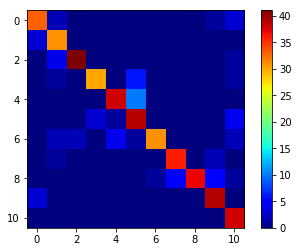

In [170]:
import numpy as np
import matplotlib.pyplot as plt

conf_arr = [[33,2,0,0,0,0,0,0,0,1,3], 
            [3,31,0,0,0,0,0,0,0,0,0], 
            [0,4,41,0,0,0,0,0,0,0,1], 
            [0,1,0,30,0,6,0,0,0,0,1], 
            [0,0,0,0,38,10,0,0,0,0,0], 
            [0,0,0,3,1,39,0,0,0,0,4], 
            [0,2,2,0,4,1,31,0,0,0,2],
            [0,1,0,0,0,0,0,36,0,2,0], 
            [0,0,0,0,0,0,1,5,37,5,1], 
            [3,0,0,0,0,0,0,0,0,39,0], 
            [0,0,0,0,0,0,0,0,0,0,38]]

norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(conf_arr), cmap=plt.cm.jet, 
                interpolation='nearest')
#width, height = parameters.number_classes,parameters.number_classes

#for x in range(width):
#    for y in range(height):
#        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
#                    horizontalalignment='center',
#                    verticalalignment='center')

cb = fig.colorbar(res)
#alphabet = '0123'
#plt.xticks(range(width), alphabet[:width])
#plt.yticks(range(height), alphabet[:height])
plt.show()

In [ ]:
from graphviz import Digraph
import re
import torchvision.models as models


def make_dot(var):
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_nodes(var):
        if var not in seen:
            if isinstance(var, Variable):
                value = '('+(', ').join(['%d'% v for v in var.size()])+')'
                dot.node(str(id(var)), str(value), fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'previous_functions'):
                for u in var.previous_functions:
                    dot.edge(str(id(u[0])), str(id(var)))
                    add_nodes(u[0])
    add_nodes(var.creator)
    return dot

In [12]:
import os
import os.path
import numpy as np
from PIL import Image
import torch.utils.data as data

#from ..utils.cityscapes import labels as cityscapes_labels
cityscapes_labels = labels

class Cityscapes(data.Dataset):
    
    # Images name subfolder in the root folder of the dataset
    images_subfolder = 'leftImg8bit'
    
    # Annotation name subfolder in the root folder of the dataset
    annotations_subfolder = 'gtFine'
        
    # Names of the folders containing train/val/test splits
    dataset_types = ['train', 'val', 'test']
    
    # Train labels which are used to map the labels
    # in the annotation images into train labels
    # Some variables in the annotatio are ignore for example
    # See utils.cityscapes for more details
    ordered_train_labels = np.asarray( list(map(lambda x: x.trainId,cityscapes_labels) ))
    print(ordered_train_labels)
    number_of_classes = 19

    
    def __init__(self,
                 dataset_root,
                 dataset_type=0,
                 train=True,
                 joint_transform=None):
        
        # dataset_root should point to a folder
        # with gtFine and leftImg8bit folders containing
        # annotations and images respectively.
        
        # dataset_type:
        # 0 - train
        # 1 - val
        # 2 - test
        
        self.dataset_root = dataset_root
        self.joint_transform = joint_transform

        dataset_type_name = self.dataset_types[dataset_type]

        images_folder_path = os.path.join(dataset_root, self.images_subfolder, dataset_type_name)
        annotations_folder_path = os.path.join(dataset_root, self.annotations_subfolder, dataset_type_name)

        self.images_filenames = []
        self.annotations_filenames = []

        for dirpath, dirnames, filenames in os.walk(images_folder_path):

            for filename in filenames:

                image_filename = os.path.join(dirpath, filename)

                annotation_filename = os.path.join( dirpath.replace(images_folder_path, annotations_folder_path),
                                                    filename.replace('leftImg8bit', 'gtFine_labelTrainIds') )

                self.images_filenames.append( image_filename )
                self.annotations_filenames.append( annotation_filename )

        
        
    def __len__(self):
        return len(self.images_filenames)
    

    def __getitem__(self, index):

        img_path = self.images_filenames[index]
        annotation_path = self.annotations_filenames[index]

        _img = Image.open(img_path).convert('RGB')
        
        # TODO: maybe can be done in a better way
        _target = Image.open(annotation_path)
        
        _target_np = np.asarray(_target)
        
        # https://stackoverflow.com/questions/8188726/how-do-i-do-this-array-lookup-replace-with-numpy
        _target_np = self.ordered_train_labels[_target_np].astype(np.uint8)
        
        _target = Image.fromarray(_target_np)

        if self.joint_transform is not None:
            _img, _target = self.joint_transform([_img, _target])
        return _img, _target

[255 255 255 255 255 255 255   0   1 255 255   2   3   4 255 255 255   5
 255   6   7   8   9  10  11  12  13  14  15 255 255  16  17  18  -1]


In [ ]:
"""
    Test function : IoU
    return a matrix of confusion
"""
def IoU(y_train_estimated, y_train):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_train_estimated, dim=1)[1]

    confusion_matrix = [[0] * parameters.number_classes for i in range(parameters.number_classes)]
    
    pred = pred.view(-1)
    target = y_train.view(-1)

    # Double loop over the number of classes at each iteration we add the intersection
    for cls1 in range(parameters.number_classes):
        pred_inds = pred == cls1
        for cls2 in range(parameters.number_classes):
            target_inds = target == cls2
            intersection = (pred_inds*target_inds).long().sum().data.cpu()[0]
            confusion_matrix[cls1][cls2] = intersection

    return(confusion_matrix)
    

In [ ]:
"""
    Test function : IoU
    return a matrix of confusion
"""
def IoU(y_train_estimated, y_train):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_train_estimated, dim=1)[1]

    confusion_matrix = [[0] * parameters.number_classes for i in range(parameters.number_classes)]
    
    #For each classes : [0] = TP [1] = FP [2] = FN
    IoU_each_classes = np.zeros(shape = (3,parameters.number_classes))

    pred = pred.view(-1)
    target = y_train.view(-1)

    # Double loop over the number of classes at each iteration we add the intersection
    for cls1 in range(parameters.number_classes):
        pred_inds = pred == cls1
        for cls2 in range(parameters.number_classes):
            target_inds = target == cls2
            intersection = (pred_inds*target_inds).long().sum().data.cpu()[0]
            confusion_matrix[cls1][cls2] = intersection

            # TP here for each classes
            if(cls1 == cls2):
                IoU_each_classes[0,cls1] = intersection
            # FN and FP here for each classes
            else:
                IoU_each_classes[1,cls1] = IoU_each_classes[1,cls1] + intersection
                IoU_each_classes[2,cls2] = IoU_each_classes[2,cls1] + intersection
    
    # compute the IoU value
    IoU_each_classes_total = IoU_each_classes[0,:]/np.sum(IoU_each_classes)

    return(confusion_matrix,IoU_each_classes_total, np.mean((np.float32(IoU_each_classes_total))))
    

In [70]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset


# Labels: -1 license plate, 0 unlabeled, 1 ego vehicle, 2 rectification border, 3 out of roi, 4 static, 5 dynamic, 6 ground, 7 road, 8 sidewalk, 9 parking, 10 rail track, 11 building, 12 wall, 13 fence, 14 guard rail, 15 bridge, 16 tunnel, 17 pole, 18 polegroup, 19 traffic light, 20 traffic sign, 21 vegetation, 22 terrain, 23 sky, 24 person, 25 rider, 26 car, 27 truck, 28 bus, 29 caravan, 30 trailer, 31 train, 32 motorcycle, 33 bicycle
num_classes = 20
full_to_train = {-1: 19, 0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19, 7: 0, 8: 1, 9: 19, 10: 19, 11: 2, 12: 3, 13: 4, 14: 19, 15: 19, 16: 19, 17: 5, 18: 19, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 19, 30: 19, 31: 16, 32: 17, 33: 18}
train_to_full = {0: 7, 1: 8, 2: 11, 3: 12, 4: 13, 5: 17, 6: 19, 7: 20, 8: 21, 9: 22, 10: 23, 11: 24, 12: 25, 13: 26, 14: 27, 15: 28, 16: 31, 17: 32, 18: 33, 19: 0}
full_to_colour = {0: (0, 0, 0), 7: (128, 64, 128), 8: (244, 35, 232), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153), 17: (153, 153, 153), 19: (250, 170, 30), 20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: (70, 130, 180), 24: (220, 20, 60), 25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60,100), 31: (0, 80, 100), 32: (0, 0, 230), 33: (119, 11, 32)}


class CityscapesDataset(Dataset):
    def __init__(self, split, crop=None, flip=False):
        super().__init__()
        self.crop = crop
        self.flip = flip
        self.inputs = []
        self.targets = []
        for root, _, filenames in os.walk(path+"/leftImg8bit/"+split):
            for filename in filenames:
                if os.path.splitext(filename)[1] == '.png':
                    filename_base = '_'.join(filename.split('_')[:-1])
                    target_root = os.path.join(path+"/gtFine", split, os.path.basename(root))
                    self.inputs.append(os.path.join(root, filename_base + '_leftImg8bit.png'))
                    self.targets.append(os.path.join(target_root, filename_base + '_gtFine_labelIds.png'))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, i):
        # Load images and perform augmentations with PIL
        img, target = Image.open(self.inputs[i]), Image.open(self.targets[i])
        # Random uniform crop
        if self.crop is not None:
            w, h = img.size
            x1, y1 = random.randint(0, w - self.crop), random.randint(0, h - self.crop)
            img, target = img.crop((x1, y1, x1 + self.crop, y1 + self.crop)), target.crop((x1, y1, x1 + self.crop, y1 + self.crop))
        # Random horizontal flip
        if self.flip:
            if random.random() < 0.5:
                img, target = img.transpose(Image.FLIP_LEFT_RIGHT), target.transpose(Image.FLIP_LEFT_RIGHT)
        
        w, h = img.size
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(h, w, 3).permute(2, 0, 1).float().div(255)
        target = torch.ByteTensor(torch.ByteStorage.from_buffer(target.tobytes())).view(h, w).long()
        
        # Normalise input
        img[0].add_(-0.485).div_(0.229)
        img[1].add_(-0.456).div_(0.224)
        img[2].add_(-0.406).div_(0.225)
        # Convert to training labels
        remapped_target = target.clone()
        for k, v in full_to_train.items():
            remapped_target[target == k] = v
        # Create one-hot encoding
        target = torch.zeros(num_classes, h, w)
        for c in range(num_classes):
            target[c][remapped_target == c] = 1
        return img, target, remapped_target # Return x, y (one-hot), y (index)
            #return img, mask